In [1]:
import numpy as np
import argparse
import torch
import os
import glob
import random
from evodiff.utils import Tokenizer
import pathlib
from sequence_models.datasets import UniRefDataset
from tqdm import tqdm
from evodiff.plot import aa_reconstruction_parity_plot
import pandas as pd
from evodiff.pretrained import CARP_38M, CARP_640M, D3PM_BLOSUM_38M, D3PM_BLOSUM_640M, D3PM_UNIFORM_38M, D3PM_UNIFORM_640M,\
                           OA_DM_640M, OA_DM_38M, LR_AR_38M, LR_AR_640M, ESM1b_650M
from matplotlib import pyplot as plt

home = str(pathlib.Path.home())

In [2]:
checkpoint = D3PM_UNIFORM_640M(return_all=True)
d3pm=True
model, collater, tokenizer, scheme, timestep, Q_bar, Q = checkpoint

torch.cuda.set_device(0)
device = torch.device('cuda:' + str(0))
model = model.eval().to(device)

sohl-dickstein


Downloading: "https://zenodo.org/record/8045076/files/d3pm-uniform-640M.tar?download=1" to /home/aa11803/.cache/torch/hub/checkpoints/d3pm-uniform-640M.tar
100%|██████████████████████████████████████| 7.19G/7.19G [03:48<00:00, 33.8MB/s]


In [3]:
data = UniRefDataset('data/uniref50/', 'train', structure=False, max_len=2048)
data_valid = UniRefDataset('data/uniref50/', 'test', structure=False, max_len=2048)

In [4]:
next(iter(data))

('MPEMIDDANLLAGLSAAASVDVEFANDPWKVLLVDDEPDVHHVLRLALHELHIDGRGLRLIDAFSAEQAKHELAAHPDIALILLDVVMETDRAGLDLVRHIRDELARRTVQIVLITGQPGYAPQRQVVSDYQIDGYLLKSELSAERVFVAVHSAIRTCRLMREQESLQADLQQKVRELDQTLVVLRESEDKLIRAQSVAHVGSWTYELASDEMHLSAETCRIFGLPAGTRGSYRSYLERVCADDRQAVEEVWRAALADGAVFQHEHRIIVGETLRHVRQQADLTRAADGTPLRCLGTTQDITERKQAEQELKRSNAELEQFSYAISHDLRQPLRMVASYLQLLGIGLAGQLDDEQREHFKFAIEGARRLDQMLVALLEYSRVGRLGEPPTWLETRAIVDEALLFLQPAIAEAQAKISVRGHWPRAWVRPDEILRLLQNLIANAAKFRVAGRRPEIRVASRVARAQWCLTVSDNGVGINRGQIGRLFQVFQRLQSRASYEGSGVGLALCRKIAEHHGGSIWADSPGEGQGSRFCVSLPLPRESA',)

In [53]:
batch_size = 100
seq_len = 110
timesteps = timestep

sample = torch.randint(0, tokenizer.K, (batch_size, seq_len))
sample = sample.to(torch.long)
sample = sample.to(device)
Q = Q.to(device)
Q_bar = Q_bar.to(device)

timesteps = torch.linspace(timesteps-1,1,int((timesteps-1)/1), dtype=int) # iterate over reverse timesteps
timesteps = timesteps.to(device)

trace = torch.zeros([timestep, batch_size, seq_len])
trace_rate = torch.zeros([timestep, batch_size, seq_len])
trace[-1] = sample
with torch.no_grad():
    for t in tqdm(timesteps):
        timesteps = torch.tensor([t] * batch_size)
        timesteps = timesteps.to(device)
        prediction = model(sample, timesteps)
        p = prediction[:, :, :tokenizer.K]  # p_theta_tilde (x_0_tilde | x_t) # Don't predict non-standard AAs
        p = torch.nn.functional.softmax(p, dim=-1)  # softmax over categorical probs
        p = p.to(torch.float64)
        x_tminus1 = sample.clone()
        for i, s in enumerate(sample):
            x_t_b = tokenizer.one_hot(s)
            A = torch.mm(x_t_b, torch.t(Q[t]))  # [P x K]
            Q_expand = Q_bar[t-1].unsqueeze(0).expand(A.shape[0], tokenizer.K, tokenizer.K)  # [ P x K x K]
            B_pred = torch.mul(p[i].unsqueeze(2), Q_expand)
            q_t = torch.mul(A.unsqueeze(1), B_pred)  # [ P x K x K ]
            p_theta_marg = torch.bmm(torch.transpose(q_t, 1,2),  p[i].unsqueeze(2)).squeeze()  # this marginalizes over dim=2
            p_theta_marg = p_theta_marg / p_theta_marg.sum(axis=1, keepdim=True)
            trace_rate[t, i, :] = 1 - (x_t_b * p_theta_marg).sum(-1)
            x_tminus1[i] = torch.multinomial(p_theta_marg, num_samples=1).squeeze()
        sample = x_tminus1
        trace[t-1] = sample

# untokenized = [tokenizer.untokenize(s) for s in sample]

100%|█████████████████████████████████████████| 499/499 [12:53<00:00,  1.55s/it]


In [19]:
x_t_b.shape

torch.Size([110, 26])

In [25]:
trace_rate.shape

torch.Size([500, 10, 110])

In [56]:
# diffs = (trace[1:] != trace[:-1]).cpu().numpy().mean(1).mean(-1)
# diffs_bwd = (trace[1:] != trace[:-1]).cpu().numpy().mean(1).mean(-1)
diffs_bwd = trace_rate.mean(-1).mean(-1)
p_muts = np.array([1 - Q[t][0, 0].cpu() for t in np.arange(len(diffs_bwd))])

In [46]:
len(p_muts)

500

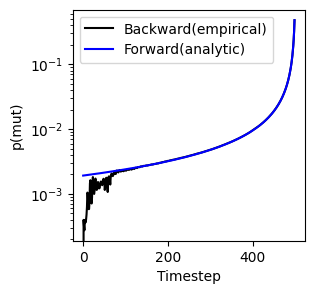

In [57]:
plt.figure(figsize=[3, 3])
plt.semilogy(diffs_bwd, label="Backward(empirical)", color='black')
plt.plot(p_muts, label="Forward(analytic)", color='blue')
plt.xlabel("Timestep")
plt.ylabel("p(mut)")
# plt.title("Uniform")
plt.legend()

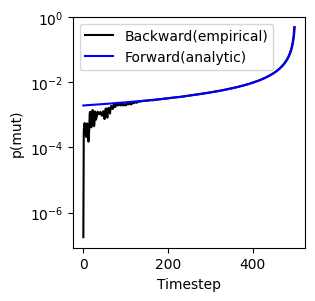

In [47]:
plt.figure(figsize=[3, 3])
plt.semilogy(diffs_bwd[1:], label="Backward(empirical)", color='black')
plt.plot(p_muts, label="Forward(analytic)", color='blue')
plt.xlabel("Timestep")
plt.ylabel("p(mut)")
# plt.title("Uniform")
plt.legend()

/tmp/ipykernel_2684394/3633354853.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(ts[:-1], moving_average(torch.tensor(rp - rt))[:-1],


(0.0, 1.0)

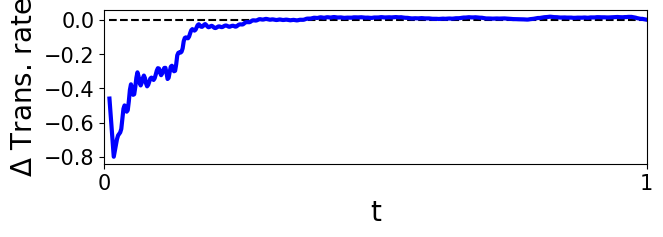

In [59]:
rp = diffs_bwd * len(diffs_bwd)
rt = p_muts * len(diffs_bwd)
ts = np.linspace(0.01, 1, len(diffs_bwd))


def moving_average(x, window=9):
    return torch.nn.functional.avg_pool1d(x.unsqueeze(0), window, stride=1, padding=window//2).squeeze(0)
plt.figure(figsize=[7, 2])
plt.plot(ts, 0*ts, color='black', ls='--')
plt.plot(ts[:-1], moving_average(torch.tensor(rp - rt))[:-1],
         lw=3, color='blue')
plt.ylabel("$\Delta$ Trans. rate", fontsize=20)
plt.xlabel("t", fontsize=20)
plt.xticks([0, 1], [0, 1],fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim(-5, 10)
plt.xlim(0, 1)
# plt.tight_layout()

### forward

In [125]:
[data[i] for i in range(100)]


[('MPEMIDDANLLAGLSAAASVDVEFANDPWKVLLVDDEPDVHHVLRLALHELHIDGRGLRLIDAFSAEQAKHELAAHPDIALILLDVVMETDRAGLDLVRHIRDELARRTVQIVLITGQPGYAPQRQVVSDYQIDGYLLKSELSAERVFVAVHSAIRTCRLMREQESLQADLQQKVRELDQTLVVLRESEDKLIRAQSVAHVGSWTYELASDEMHLSAETCRIFGLPAGTRGSYRSYLERVCADDRQAVEEVWRAALADGAVFQHEHRIIVGETLRHVRQQADLTRAADGTPLRCLGTTQDITERKQAEQELKRSNAELEQFSYAISHDLRQPLRMVASYLQLLGIGLAGQLDDEQREHFKFAIEGARRLDQMLVALLEYSRVGRLGEPPTWLETRAIVDEALLFLQPAIAEAQAKISVRGHWPRAWVRPDEILRLLQNLIANAAKFRVAGRRPEIRVASRVARAQWCLTVSDNGVGINRGQIGRLFQVFQRLQSRASYEGSGVGLALCRKIAEHHGGSIWADSPGEGQGSRFCVSLPLPRESA',),
 ('MTDPDSREVLAAFFPERAGELQEWAAEAAMSRLYGGIHFRSDNSEGLRLGRAVGRRVVERSLGGAGADSGGGRLRPAAQDAAQ',),
 ('MQADAAYARLREAIVDGQYPAGARLTEVEIAETLGMSRTPVREALRRLAGDGLVRASDRGVIVDLMDEEEAWHARTVRAALDVLVAELAARRQKAGEVSPAALRAAEEAAASARTYLERGDTDEAYRHDQRLHRQIAEIAGNPVALQMLDRLADRLEVARLAAASRAERAKNIEKKVDGIHLVTKVPAAVGAGFDGDVRSGLDLNGHAVNGANGSHGAGADKPGAEGATGSASMKKNGTRSGGTVGDDGMGRLAVPVLSPDLAEEHRRLLDAIAAGQPAAAWLAAREHAHG',),
 ('MLETLKVKNHTFGLGYQQIMGESAYPLPDGFLPETYFINWNATGFFKEDEKSYHVM

In [126]:


def fwd_sample(seq, Q=Q, Q_bar=Q_bar, timestep=timestep):
    sample = torch.tensor(np.array([tokenizer.tokenize(s) for s in seq])[None, :, 0])
    sample = sample.to(torch.long)
    sample = sample.to(device)
    Q = Q.to(device)
    Q_bar = Q_bar.to(device)

    timesteps = timestep
    timesteps = torch.linspace(1, timesteps-1,int((timesteps-1)/1), dtype=int) # iterate over reverse timesteps
    timesteps = timesteps.to(device)
    
    trace = torch.zeros([timestep, len(sample), sample.shape[1]])
    trace[0] = sample
    with torch.no_grad():
        for t in tqdm(timesteps):
            timesteps = torch.tensor([t] * len(sample))
            timesteps = timesteps.to(device)
            x_tplus1 = sample.clone()
            for i, s in enumerate(sample):
                x_t_b = tokenizer.one_hot(s)
                p_theta_marg = torch.mm(x_t_b, Q[t])  # [P x K]
                p_theta_marg = p_theta_marg / p_theta_marg.sum(axis=1, keepdim=True)
                x_tplus1[i] = torch.multinomial(p_theta_marg, num_samples=1).squeeze()
            sample = x_tplus1
            trace[t] = sample
    diffs = (trace[1:] != trace[:-1]).cpu().numpy().mean(1).mean(-1)
    return diffs

In [127]:
diffs_fwd = np.array([fwd_sample(seq[0]) for i, seq in enumerate(data) if i<100]).mean(0)

100%|███████████████████████████████████████| 499/499 [00:00<00:00, 2381.39it/s]


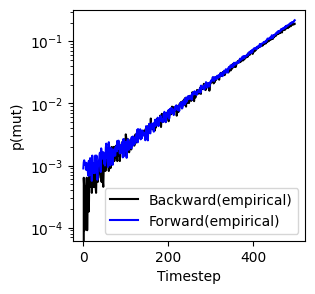

In [130]:
plt.figure(figsize=[3, 3])
plt.semilogy(diffs_bwd, label="Backward(empirical)", color='black', alpha=1)
plt.plot(diffs_fwd, label="Forward(empirical)", color='blue', alpha=1)
plt.xlabel("Timestep")
plt.ylabel("p(mut)")
# plt.title("Uniform")
plt.legend()

# Download uniref50

In [104]:
import requests
import json
import numpy as np
import random
from tqdm import tqdm
import os

def reservoir_sampling(stream, k, max_sequences):
    reservoir = []
    for i, item in enumerate(stream):
        if i >= max_sequences:
            break
        if i < k:
            reservoir.append(item)
        else:
            j = random.randint(0, i)
            if j < k:
                reservoir[j] = item
        yield i, item

def download_uniref50_random_subset(num_sequences=10000, seed=42, data_dir="data/uniref50", max_sequences=1000000):
    url = "https://rest.uniprot.org/uniref/stream?query=identity:0.5&format=fasta"
    random.seed(seed)
    
    os.makedirs(data_dir, exist_ok=True)
    
    print(f"Downloading and sampling {num_sequences} from the first {max_sequences} UniRef50 sequences...")
    response = requests.get(url, stream=True)
    
    sampled_sequences = []
    current_id = ""
    current_sequence = ""
    sequence_count = 0
    
    with tqdm(desc="Processing sequences", unit=" seq", total=max_sequences) as pbar:
        for i, line in reservoir_sampling((line.decode('utf-8').strip() for line in response.iter_lines()), num_sequences * 2, max_sequences):
            if line.startswith(">"):
                if current_id and current_sequence:
                    sampled_sequences.append((current_id, current_sequence))
                    current_sequence = ""
                    sequence_count += 1
                    if len(sampled_sequences) >= num_sequences:
                        break
                current_id = line
            else:
                current_sequence += line
            pbar.update(1)
    
    if current_id and current_sequence and len(sampled_sequences) < num_sequences:
        sampled_sequences.append((current_id, current_sequence))
    
    print(f"\nTotal sequences processed: {sequence_count}")
    print(f"Sampled sequences: {len(sampled_sequences)}")
    
    # Save sequences in FASTA format without line breaks
    with open(os.path.join(data_dir, "consensus.fasta"), "w") as f_out:
        for seq_id, seq in sampled_sequences:
            f_out.write(f"{seq_id}\n{seq}\n")
    
    return sampled_sequences

def create_splits_and_metadata(sequences, data_dir="data/uniref50"):
    total_sequences = len(sequences)
    indices = list(range(total_sequences))
    random.shuffle(indices)

    train_split = int(0.8 * total_sequences)
    valid_split = int(0.9 * total_sequences)

    splits = {
        "train": indices[:train_split],
        "valid": indices[train_split:valid_split],
        "test": indices[valid_split:]
    }

    with open(os.path.join(data_dir, "splits.json"), "w") as f:
        json.dump(splits, f)

    # Create lengths_and_offsets.npz
    offsets = []
    lengths = []
    current_offset = 0
    
    with open(os.path.join(data_dir, "consensus.fasta"), "r") as f:
        while True:
            id_line = f.readline()
            if not id_line:
                break
            seq_line = f.readline().strip()
            offsets.append(current_offset + len(id_line))
            lengths.append(len(seq_line))
            current_offset += len(id_line) + len(seq_line) + 1  # +1 for the newline after sequence

    np.savez(os.path.join(data_dir, "lengths_and_offsets.npz"), 
             seq_offsets=np.array(offsets), 
             seq_lengths=np.array(lengths))


In [105]:
print("Downloading UniRef50 dataset...")
seqs = download_uniref50_random_subset()

print("Creating splits and metadata...")
create_splits_and_metadata(seqs)

print("Data preparation complete.")

Processing sequences:   6%|▍       | 61879/1000000 [00:01<00:19, 46919.34 seq/s]


Total sequences processed: 10000
Sampled sequences: 10000
Creating splits and metadata...
Data preparation complete.
